# Predict Prices using Sentiment and ARIMA

#### Strategy:
1. Predict Sentiment 
2. Show relationship between sentiment and price
3. Create article scoring based on sentiment and price prediction


### 1. Import and Preprocess Data

#### 1.1 Import and pre-process articles

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pandas import DataFrame
from datetime import datetime,tzinfo
from pytz import timezone
import time
import pytz
import csv


plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
articles = pd.read_csv("./data/Classified Articles.csv")


In [302]:
articles.head(1)

In [4]:
articles["timeStamp"] = pd.to_datetime(articles['date'] + ' ' + articles['time'])

articles = articles.set_index("timeStamp")

In [5]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks
timeStamp,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0


In [6]:
len(articles)

40732

In [7]:
min(articles.index)

Timestamp('2018-01-23 00:00:00')

In [8]:
max(articles.index)

Timestamp('2018-03-27 23:46:45')

#### 1.1.1 Import and Pre-process hand-labeled sentiment 

In [9]:
data = pd.read_csv("./data/Articles Reading Assignment.csv")
data.head(1)

,Name,URL,Sentiment
0,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0


In [10]:
data = data.dropna()
#data["Sentiment"] += 1
#data["Sentiment"] /= 2

data["contents"] = ["" for i in range(len(data))]
data["title"] = ["" for i in range(len(data))]
data["date"] = ["" for i in range(len(data))]
data["time"] = ["" for i in range(len(data))]
data["marks"] = ["" for i in range(len(data))]


for i, row in data.iterrows():
    x = row["URL"]
    
    key_words = articles[articles["source_url"] == x][:1]["contents"].values[0]
    data.at[i, "contents"] = str(key_words)
    
    title = articles[articles["source_url"] == x][:1]["title"].values[0]
    data.at[i, "title"] = str(title)
    
    date = articles[articles["source_url"] == x][:1]["date"].values[0]
    data.at[i, "date"] = date
    
    time = articles[articles["source_url"] == x][:1]["time"].values[0]
    data.at[i, "time"] = time
    
    marks = articles[articles["source_url"] == x][:1]["marks"].values[0]
    data.at[i, "marks"] = marks
      
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
0,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [11]:
data["timeStamp"] = pd.to_datetime(data['date'] + ' ' + data['time'])

data = data.set_index("timeStamp")

In [12]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [13]:
len(data.loc[data["Sentiment"] == data["marks"]])

83

In [14]:
len(data)

246

In [15]:
data["Sentiment"] = pd.to_numeric(data["Sentiment"])
data["marks"] = pd.to_numeric(data["marks"])

In [16]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


#### 1.2 Import and pre-process Bitcoin price data 

In [17]:
# import data: bitcoin prices
btc = pd.read_csv("./data/coinbaseUSD_1-min_data_2014-12-01_to_2018-03-27.csv")

# preprocess bitcoin price data 
btc.Timestamp = pd.to_datetime(btc.Timestamp, unit='s')
btc.Timestamp = btc.Timestamp.dt.tz_localize('UTC')

btc['log_close'] = np.log(btc.Close) - np.log(btc.Close.shift(1))
btc['Date'] = pd.to_datetime(btc['Timestamp']).dt.date

min_periods = 43200 # 60minutes*24hours*30days 

price=btc['Close']
# Calculate the sd and volatility
mean=price.rolling(min_periods).mean()
sd=price.rolling(min_periods).std()
vol = price.rolling(min_periods).std() * np.sqrt(min_periods) 
btc['Average']=mean
btc['Volatility']=vol
btc['SD']=sd

price_log=btc['log_close']
# Calculate the sd and volatility
mean=price_log.rolling(min_periods).mean()
sd=price_log.rolling(min_periods).std()
vol = price_log.rolling(min_periods).std() * np.sqrt(min_periods) 
btc['Average_log']=mean
btc['Volatility_log']=vol
btc['SD_log']=sd

index_1 = btc[btc.Date == datetime.date(dt.datetime.strptime('01/23/18', '%x'))].index[0]
index_2 = btc[btc.Date == datetime.date(dt.datetime.strptime('03/27/18', '%x'))].index[0]
btc_1= btc.loc[index_1:index_2]

btc_1 = btc_1.set_index("Timestamp")


In [18]:
max(articles.index)

Timestamp('2018-03-27 23:46:45')

In [19]:
min(articles.index)

Timestamp('2018-01-23 00:00:00')

Plot data

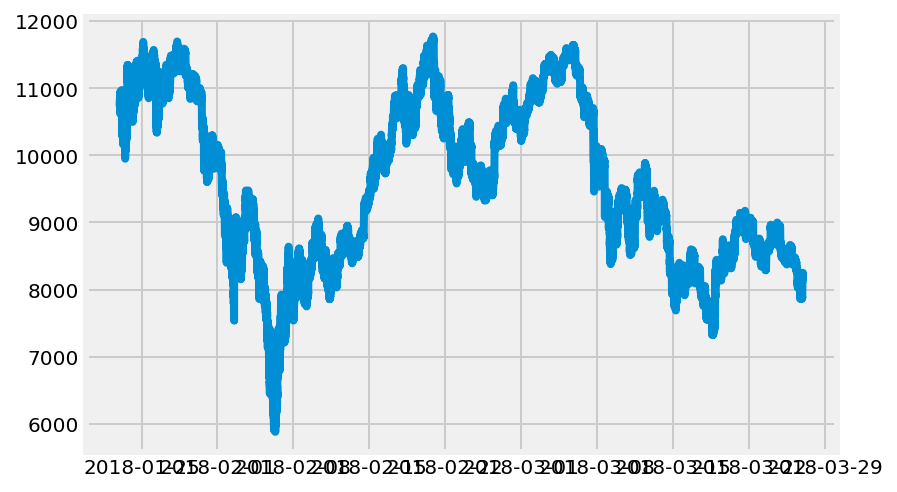

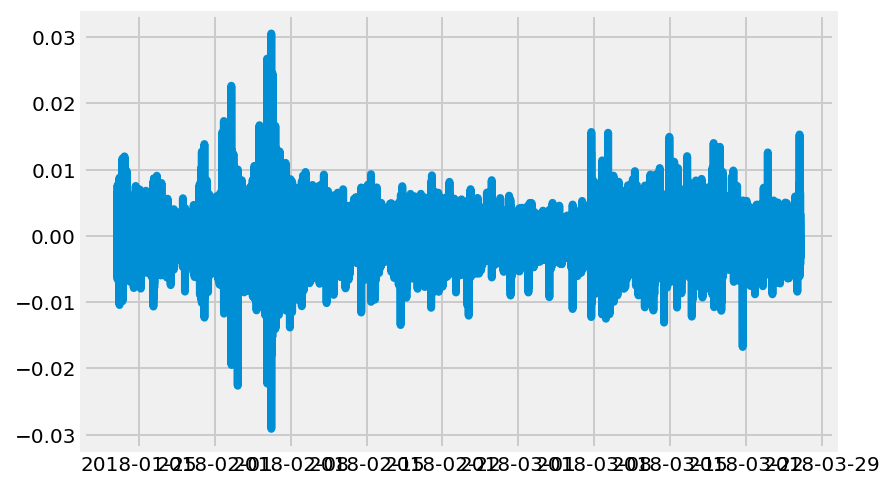

In [20]:
btc_close = btc_1['Close']
plt.plot(btc_close)
plt.show()


btc_log_close = btc_1['log_close']
plt.plot(btc_log_close)
plt.show()


Create function to change Bitcoin-Price to any time frame

### 1.3 Create lags of responses and merge data from 1 and 2

In [21]:
# create response add response with multiple lags in seconds
import datetime
import time

start = time.time()

response = pd.DataFrame()
benchmark_naive = pd.DataFrame()

# 1 minute, 5 minutes, 10 minutes, 30 minutes, 60 minutes, 12 hours, 1 day, 2 days, 4 days 
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
            "lag_2d":172800,"lag_4d" : 345600}


train_time = pd.to_datetime(articles.index)

for colname in colnames:
    count = 0
    stock_return = []
    stock_return_naive = []
    lag = colnames[colname]
    
    for i in train_time:
        count +=1
        try:
            start_price = btc_1.Close.iloc[btc_1.index.get_loc(i,method = "nearest")]
            end_price = btc_1.Close.iloc[btc_1.index.get_loc((i+datetime.timedelta(0,lag)),method = "nearest")]
            stock_return.append(end_price/start_price-1)
            
            end_price_naive = btc_1.Close.iloc[btc_1.index.get_loc(i,method = "nearest")]
            start_price_naive = btc_1.Close.iloc[btc_1.index.get_loc((i-datetime.timedelta(0,lag)),method = "nearest")]
            stock_return_naive.append(end_price_naive/start_price_naive-1)
            
            #if lag ==86400:
               # print(start_price,i)
                #print(end_price,(i+datetime.timedelta(0,lag)))
                #print("")
        except:
            stock_return.append(0)
            stock_return_naive.append(0)
            print("exception raised")
        #if count ==10:
            #break
    response[colname] = stock_return
    benchmark_naive[colname] = stock_return_naive
    

print("time elapsed:",round((time.time()-start)/60,1),"minutes")

time elapsed: 25.0 minutes


In [22]:
response.head(1)

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566


In [23]:
benchmark_naive.head(1)

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.4.1 Sentiment Assignment 

In [24]:
data.head(1)

,Name,URL,Sentiment,contents,title,date,time,marks
timeStamp,,,,,,,,
2018-03-21 11:54:35,Sudarshan,https://www.wykop.pl/link/4223359/blockchain-a...,0.0,ciastka strona korzysta z plik w cookies w cel...,Blockchain & Bitcoin Conference Berlin on Apri...,2018-03-21,11:54:35,1


In [25]:
len(data)

246

#### 1.4.1.1 NLP 

In [26]:
# create class which handles NLP tokenization, stemming/lemmatizing and tranformation to vector 
class nlp_validation_sets:
    
    def __init__(self,fold,validation,train_data,max_features=10,method_nlp = "stem",ngram = 1):
        self.fold = fold
        self.validation = validation
        self.max_features = max_features 
        self.method_nlp = method_nlp
        self.ngram = ngram
        self.train_data = train_data
        
        self.stemmed_word_list = []
        self.tokenized_word_list = []
        self.stemmed_word_list_only_bad = []
        self.tokenized_word_list_only_bad = []
        self.stemmed_word_list_val = []
        self.tokenized_word_list_val = []
        self.stemmed_word_list_train = []
        self.tokenized_word_list_train = []
    
    def choose_w2v(self,method = "tfidf"):
        from sklearn.feature_extraction.text import CountVectorizer
        from sklearn.feature_extraction.text import TfidfVectorizer
        
        if method == "tfidf":
            self.tfidf = TfidfVectorizer(max_features = self.max_features,ngram_range =(1,self.ngram),
                                        max_df = 1.0,min_df = 1)
        if method == "count":
            self.tfidf = CountVectorizer(max_features = self.max_features,ngram_range = (1,self.ngram),
                                        max_df = 1.0,min_df = 1)
        
    def fit(self):
        import time 
        from nltk.stem.porter import PorterStemmer
        from nltk.corpus import stopwords
        import re
         
        start = time.time()
        stop_words_english = set(stopwords.words('english'))
        
        stem = PorterStemmer()

        
        for text in self.fold.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list.append(" ".join(str(x) for x in token_words))
            
        for text in self.train_data.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list_train.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list_train.append(" ".join(str(x) for x in token_words))
        
        
        if self.method_nlp == "stem":
            self.tfidf.fit(self.stemmed_word_list_train)
        if self.method_nlp == "token":
            self.tfidf.fit(self.tokenized_word_list_train)
                
                
        for text in self.validation.contents:
            wordList = re.sub("[^\w]", " ",text).split()
            stem_words = []
            token_words = []
    
            for word in wordList: 
                if not word.lower() in stop_words_english: 
                    stem_words.append(stem.stem(word.lower()))
                    token_words.append(word.lower())
    
            self.stemmed_word_list_val.append(" ".join(str(x) for x in stem_words))
            self.tokenized_word_list_val.append(" ".join(str(x) for x in token_words))
    
        print("time elapsed",round((time.time()-start)/60,1))
        
    def transform_test(self):
        if self.method_nlp == "stem":
            return self.tfidf.transform(self.stemmed_word_list_val)
        if self.method_nlp == "token":
            return self.tfidf.transform(self.tokenized_word_list_val)
            
    
    def transform_train(self):
        return self.tfidf.transform(self.stemmed_word_list)
                    

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train_sen, Y_test_sen = train_test_split(data,data.Sentiment, test_size = 0.25, random_state = 42)
X_train, X_test, Y_train_mar, Y_test_mar = train_test_split(data,data.marks, test_size = 0.25, random_state = 42)

In [28]:
X_test.shape

(62, 8)

In [29]:
X_train.shape

(184, 8)

In [30]:
sentiment_nlp = nlp_validation_sets(fold = X_train,validation = X_test,train_data = X_train,
                                    max_features=100,method_nlp = "stem",ngram = 1)

In [31]:
sentiment_nlp.choose_w2v(method = "tfidf")

In [32]:
sentiment_nlp.fit()

time elapsed 0.1


In [33]:
X = sentiment_nlp.transform_train()
X.shape

(184, 100)

In [34]:
X_test = sentiment_nlp.transform_test()
X_test.shape

(62, 100)

#### 1.4.1.2 Model fitting

##### Marks 

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X,Y_train_mar)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
pred = lr.predict(X_test)
pred

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1])

In [37]:
accuracy_score(Y_test_mar,pred)

0.45161290322580644

In [38]:
print("no information accuracy", np.mean(Y_test_mar))

no information accuracy 0.4838709677419355


In [39]:
confusion_matrix(pred,Y_test_mar)

array([[10, 12],
       [22, 18]])

#### Hand-labeled Sentiment

#### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()

n_estimators = [500]
max_features = [.3,.5,.7,1.0]
max_depth = [None]

param_grid = {'n_estimators': n_estimators,'max_features': max_features,"max_depth":max_depth}
    
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

 
# Fit the random search model
grid_search.fit(X, Y_train_sen)

best_param = grid_search.best_params_

rf_d = RandomForestClassifier(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"])
rf_d.fit(X,Y_train_sen)

pred = rf_d.predict(X_test)


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    6.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    6.4s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [41]:
best_param

{'max_depth': None, 'max_features': 1.0, 'n_estimators': 500}

In [42]:
pred

array([ 0., -1.,  1.,  1., -1.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0., -1., -1.,  1., -1.,  0.,  0.,  0.,  0., -1.,
       -1.,  1.,  0., -1.,  0.,  0.,  1.,  0., -1.,  0.,  0.,  0., -1.,
       -1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0., -1.])

In [43]:
accuracy_score(Y_test_sen,pred)

0.532258064516129

In [44]:
print("no information accuracy", len(X_train.loc[X_train.Sentiment == 0])/len(X_train))

no information accuracy 0.45652173913043476


In [45]:
confusion_matrix(Y_test_sen,pred)

array([[ 9,  6,  1],
       [ 3, 22,  3],
       [ 8,  8,  2]])

#### Gradient Boosting

In [46]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


gbm = GradientBoostingClassifier()
    
max_features = [0.3,0.6,0.8]
subsample = [1]
max_depth = [1,3,6]
learning_rate = [.01]
n_estimators=[50,100,150,200]

param_grid = {'max_features': max_features,"max_depth":max_depth,
                 "subsample":subsample,"learning_rate":learning_rate,"n_estimators":n_estimators}
    

grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                      cv = 2, n_jobs = -1, verbose = 2)

# Fit the random search model
grid_search.fit(X,Y_train_sen)

best_param = grid_search.best_params_




gbm_d = GradientBoostingClassifier(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"],learning_rate = best_param["learning_rate"])
gbm_d.fit(X,Y_train_sen)

pred = gbm_d.predict(X_test)


Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   16.8s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [47]:
best_param

{'learning_rate': 0.01,
 'max_depth': 6,
 'max_features': 0.3,
 'n_estimators': 150,
 'subsample': 1}

In [48]:
pred

array([ 0., -1., -1.,  1., -1.,  0.,  0.,  0., -1.,  1., -1.,  0.,  0.,
        0.,  0.,  0., -1.,  1., -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
       -1.,  1.,  0.,  0., -1., -1.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        1., -1.,  1.,  0.,  0.,  0., -1.,  0.,  0., -1.])

In [49]:
accuracy_score(Y_test_sen,pred)

0.46774193548387094

In [50]:
print("no information accuracy", len(X_train.loc[X_train.Sentiment == 0])/len(X_train))

no information accuracy 0.45652173913043476


In [51]:
confusion_matrix(Y_test_sen,pred)

array([[ 8,  6,  2],
       [ 4, 19,  5],
       [ 6, 10,  2]])

#### Prediction  

In [52]:
main_articles_nlp = nlp_validation_sets(fold = X_train,validation = articles,train_data = X_train,
                                    max_features=100,method_nlp = "stem",ngram = 1)

main_articles_nlp.choose_w2v(method = "count")
main_articles_nlp.fit()
X = main_articles_nlp.transform_test()

time elapsed 8.5


In [53]:
X.shape

(40732, 100)

In [54]:
pred_main_articles = rf_d.predict(X)

In [55]:
pred_main_articles.shape

(40732,)

In [56]:
articles["predicted_sentiment"] = pred_main_articles

In [57]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks,predicted_sentiment
timeStamp,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0,1.0


In [58]:
articles.to_csv("Classified Articles with Predicted Sentiment")

## 2. Relationship between Sentiment and Price 

### 2.1 train test split

In [59]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,label,c,marks,predicted_sentiment
timeStamp,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,0.0,"['complete', 'payments', 'platform', 'engineer...",0,1.0


In [60]:
articles.shape

(40732, 14)

In [61]:
response.shape

(40732, 9)

In [62]:
response.head()

,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566
1,0.004785,0.009881,0.007196,0.009790,5.649444e-03,-0.006864,0.001948,-0.131626,-0.099480
2,0.004785,0.009881,0.007196,0.009790,5.649444e-03,-0.006864,0.001948,-0.131626,-0.099480
3,-0.001834,-0.002659,-0.000428,-0.000899,1.532112e-03,-0.017489,-0.006412,-0.138672,-0.107204
4,-0.001857,-0.000064,0.002453,0.000936,3.372913e-03,-0.015684,-0.004587,-0.138783,-0.105564


In [63]:
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

response = response.set_index(articles.index)
for i in colnames:
    articles[i] = response[i]

In [64]:

#split = .75
#train = articles.iloc[0:(round(len(articles)*split)),:]
#test = articles.iloc[-(round(len(articles)*(1-split))):]

#train_response = response.iloc[0:(round(len(response)*split)),:]
#test_response = response.iloc[-(round(len(response)*(1-split))):]

#train_naive = benchmark_naive.iloc[0:(round(len(benchmark_naive)*split)),:]

#test_naive = benchmark_naive.iloc[-(round(len(benchmark_naive)*(1-split))):]


In [96]:
from sklearn.model_selection import train_test_split

train, test, train_response, test_response = train_test_split(articles,response, test_size = 0.25, random_state = 42)
train_naive,test_naive,a,b = train_test_split(benchmark_naive,response, test_size = 0.25, random_state = 42)


In [97]:
train.shape

(30549, 23)

In [98]:
train_response.shape

(30549, 9)

In [99]:
test.shape

(10183, 23)

In [100]:
articles.shape

(40732, 23)

In [101]:
test_response.shape

(10183, 9)

In [102]:
test.shape

(10183, 23)

In [103]:
train_response.shape

(30549, 9)

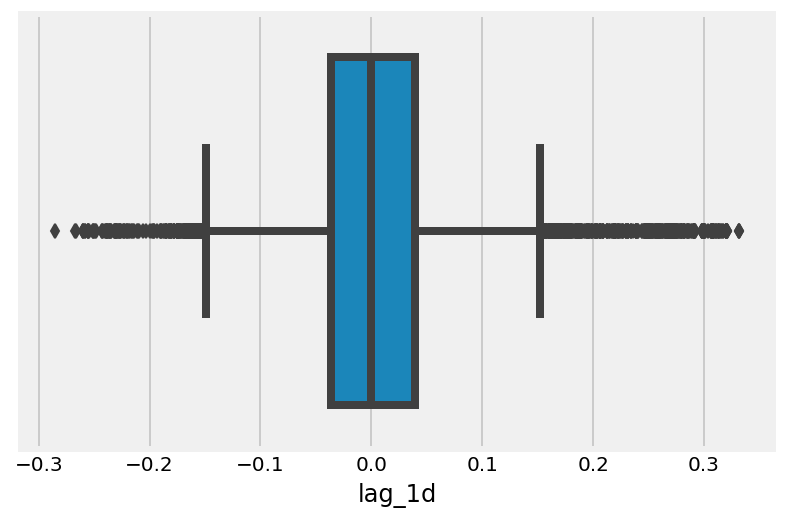

In [104]:
sns.boxplot(train_response["lag_1d"])

In [105]:
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

### 2.2 Mean Difference for Sentiment 

In [106]:
articles.head(1)

,Unnamed: 0,index,author,contents,description,publisher,source_url,title,date,time,...,predicted_sentiment,lag_1m,lag_5m,lag_10m,lag_30m,lag_60m,lag_12h,lag_1d,lag_2d,lag_4d
timeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-23,0,0,Stripe.com,complete payments platform engineered growth b...,"At Stripe, we’ve long been excited about the p...",Stripe.com,https://stripe.com/blog/ending-bitcoin-support,Ending Bitcoin Support,2018-01-23,00:00:00,...,1.0,-0.000255,-0.004628,0.003677,-0.006573,9.259276e-07,-0.066983,0.008283,0.048753,0.026566


In [73]:
round(np.mean(articles.lag_30m)*100,4)

0.0022

In [74]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==0.0])*100,4)

-0.0117

In [75]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==1.0])*100,4)

-0.0109

In [76]:
round(np.mean(articles.lag_30m.loc[articles.predicted_sentiment==-1.0])*100,4)

0.0259

In [77]:
round(np.mean(articles.lag_30m.loc[articles.marks==0.0])*100,4)

-0.0109

In [78]:
round(np.mean(articles.lag_30m.loc[articles.marks==1.0])*100,4)

0.0072

### 2.3 Evaluate difference using linear regression 

In [107]:
import statsmodels.api as sm

for j in colnames:
    
    lm = sm.OLS(articles[j],sm.add_constant(articles.predicted_sentiment)).fit()
    
    print("OLS for ",j)
    print(lm.summary())
    print("")
    print("")

OLS for  lag_1m
                            OLS Regression Results                            
Dep. Variable:                 lag_1m   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     10.14
Date:                Sun, 02 Dec 2018   Prob (F-statistic):            0.00146
Time:                        22:59:43   Log-Likelihood:             1.9797e+05
No. Observations:               40732   AIC:                        -3.959e+05
Df Residuals:                   40730   BIC:                        -3.959e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

OLS for  lag_4d
                            OLS Regression Results                            
Dep. Variable:                 lag_4d   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.202
Date:                Sun, 02 Dec 2018   Prob (F-statistic):              0.273
Time:                        22:59:43   Log-Likelihood:                 26638.
No. Observations:               40732   AIC:                        -5.327e+04
Df Residuals:                   40730   BIC:                        -5.326e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const             

In [108]:
import statsmodels.api as sm

for j in colnames:
    
    lm = sm.OLS(articles[j],sm.add_constant(articles.marks)).fit()
    
    print("OLS for ",j)
    print(lm.summary())
    print("")
    print("")




OLS for  lag_1m
                            OLS Regression Results                            
Dep. Variable:                 lag_1m   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5884
Date:                Sun, 02 Dec 2018   Prob (F-statistic):              0.443
Time:                        22:59:45   Log-Likelihood:             1.9797e+05
No. Observations:               40732   AIC:                        -3.959e+05
Df Residuals:                   40730   BIC:                        -3.959e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.335e-05   1.77e-05    

#### what if we add past price as additional predictor?

## 3. Article Scoring

### 3.1 nlp features 

In [109]:
nlp = nlp_validation_sets(fold = train,validation = test,train_data = articles,max_features=100,method_nlp = "stem",ngram = 1)

In [110]:
nlp.choose_w2v(method = "count")

In [111]:
nlp.fit()

time elapsed 17.1


In [112]:
X = nlp.transform_train()

In [113]:
X_test = nlp.transform_test()

In [114]:
X.shape

(30549, 100)

In [115]:
X_test.shape

(10183, 100)

### 3.2 train models and evaluate models 

In [116]:
train_response.shape

(30549, 9)

In [117]:
X.shape

(30549, 100)

In [118]:
X_test.shape

(10183, 100)

In [119]:
test_response.shape

(10183, 9)

### 3.3 benchmark: naive (use last price change as predictor for current price change)

In [120]:
from sklearn.metrics import mean_squared_error
colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

for j in colnames:
    print("benchmark training error:",j,":",round(mean_squared_error(train_response[j],train_naive[j]),5))


benchmark training error: lag_1m : 1e-05
benchmark training error: lag_5m : 3e-05
benchmark training error: lag_10m : 7e-05
benchmark training error: lag_30m : 0.0002
benchmark training error: lag_60m : 0.00041
benchmark training error: lag_12h : 0.00396
benchmark training error: lag_1d : 0.00889
benchmark training error: lag_2d : 0.01603
benchmark training error: lag_4d : 0.02818


In [121]:
for j in colnames:
    print("benchmark testing error:",j,":",round(mean_squared_error(test_response[j],test_naive[j]),5))

benchmark testing error: lag_1m : 1e-05
benchmark testing error: lag_5m : 3e-05
benchmark testing error: lag_10m : 6e-05
benchmark testing error: lag_30m : 0.00019
benchmark testing error: lag_60m : 0.0004
benchmark testing error: lag_12h : 0.00397
benchmark testing error: lag_1d : 0.00893
benchmark testing error: lag_2d : 0.01604
benchmark testing error: lag_4d : 0.02795


### 3.4 benchmark: AR-1 linear regresion (use weighted past price change as predictor for current price change)

In [122]:
from sklearn.linear_model import LinearRegression
for j in colnames:
    reg = LinearRegression()
    reg.fit(train_naive,train_response[j])
    #pred = reg.predict(train_naive)
    #print("linear regression training error:",j,round(mean_squared_error(pred,train_response[j])/
                                                      #mean_squared_error(train_response[j],train_naive[j]),5))
    pred = reg.predict(test_naive)
    #print("")
    print("AR-1 linear regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))

AR-1 linear regression test error: lag_1m 0.52073
AR-1 linear regression test error: lag_5m 0.52643
AR-1 linear regression test error: lag_10m 0.49202
AR-1 linear regression test error: lag_30m 0.49134
AR-1 linear regression test error: lag_60m 0.46501
AR-1 linear regression test error: lag_12h 0.47748
AR-1 linear regression test error: lag_1d 0.42965
AR-1 linear regression test error: lag_2d 0.4483
AR-1 linear regression test error: lag_4d 0.56196


### 3.5 linear regression with NLP features

#### 2.3.1 NLP features only

In [123]:
X = np.concatenate((X.toarray(),train[["predicted_sentiment"]].values),axis = 1)

In [124]:
X.shape

(30549, 101)

In [125]:
X_test = np.concatenate((X_test.toarray(),test[["predicted_sentiment"]].values),axis = 1)

In [126]:
X_test.shape

(10183, 101)

In [127]:
test_response.shape

(10183, 9)

In [128]:
# linear regression: train 
#a = np.concatenate((X,train_dummies),axis = 1)
#b = np.concatenate((X_test,test_dummies),axis = 1)
for j in colnames:
    reg = LinearRegression()
    reg.fit(X,train_response[j])
    #pred = reg.predict(X)
    #print("linear regression training error:",j,round(mean_squared_error(pred,train_response[j])/
       #                                               mean_squared_error(train_response[j],train_naive[j]),5))
    pred = reg.predict(X_test)
    #print("")
    print("linear regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))

linear regression test error: lag_1m 0.52084
linear regression test error: lag_5m 0.52696
linear regression test error: lag_10m 0.49382
linear regression test error: lag_30m 0.49053
linear regression test error: lag_60m 0.46523
linear regression test error: lag_12h 0.48613
linear regression test error: lag_1d 0.43401
linear regression test error: lag_2d 0.44412
linear regression test error: lag_4d 0.55177


### 3.6 lasso regression with NLP features (with 5-fold cross validation)

In [129]:
#from: https://www.kaggle.com/floser/aw6-the-lasso-cross-validated
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
#from sklearn import cross_validation

for j in colnames:
    alphas = [1,5,10,50,100,1000]
    lassocv = LassoCV(alphas=alphas, cv=5, max_iter=100000, normalize=True)
    lassocv.fit(X, train_response[j])
    lasso = Lasso()
    lasso.set_params(alpha=lassocv.alpha_)
    #print("Alpha=", lassocv.alpha_)
    lasso.fit(X, train_response[j])
    #print("mse = ",mean_squared_error(y_test, lasso.predict(X_test)))
    #print("best model coefficients:")
    #pd.Series(lasso.coef_, index=X.columns)
    #pred = lasso.predict(X)
    #print("lasso regression training error:",j,round(mean_squared_error(pred,train_response[j])/
                                                      #mean_squared_error(train_response[j],train_naive[j]),5))
    
    pred = lasso.predict(X_test)
    print("lasso R squared:",j,lasso.score(X,train_response[j]))
    print("lasso regression test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
    

lasso R squared: lag_1m 0.0
lasso regression test error: lag_1m 0.52028
lasso R squared: lag_5m 0.0
lasso regression test error: lag_5m 0.52693
lasso R squared: lag_10m 0.0
lasso regression test error: lag_10m 0.49379
lasso R squared: lag_30m 0.0
lasso regression test error: lag_30m 0.49205
lasso R squared: lag_60m 0.0
lasso regression test error: lag_60m 0.46784
lasso R squared: lag_12h 0.0
lasso regression test error: lag_12h 0.49192
lasso R squared: lag_1d 0.0
lasso regression test error: lag_1d 0.44055
lasso R squared: lag_2d 0.0
lasso regression test error: lag_2d 0.45166
lasso R squared: lag_4d 0.0
lasso regression test error: lag_4d 0.56981


### 3.7 random forest regressor with NLP features

In [130]:
#from: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

start = time.time()

colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

model = ["lag_1d"]
count = 0
for j in model:
    count+=1
    
    #a = np.concatenate((train_dummies,np.array(train_naive[j]).reshape(len(train_naive[j]),1),X),axis = 1)
    #b = np.concatenate((test_dummies,np.array(test_naive[j]).reshape(len(test_naive[j]),1),X_test),axis = 1)
    
    rf = RandomForestRegressor()
    
    n_estimators = [500]
    max_features = [.3]
    max_depth = [None]

    param_grid = {'n_estimators': n_estimators,'max_features': max_features,"max_depth":max_depth}
    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2,scoring = "neg_mean_squared_error")

    #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, 
                               #cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    grid_search.fit(X, train_response[j])

    best_param = grid_search.best_params_

    rf_d = RandomForestRegressor(n_estimators = best_param["n_estimators"],max_features = best_param["max_features"]
                             ,max_depth = best_param["max_depth"])
    rf_d.fit(X,train_response[j])

    pred = rf_d.predict(X_test)
    pred_rf = rf_d.predict(X_test)

    print("random forest test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
    #if count>0:
       # break 
print("time elapsed:",round((time.time()-start)/60,1),"minutes")

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.2min finished


random forest test error: lag_1d 0.15124
time elapsed: 6.7 minutes


In [131]:
best_param

{'max_depth': None, 'max_features': 0.3, 'n_estimators': 500}

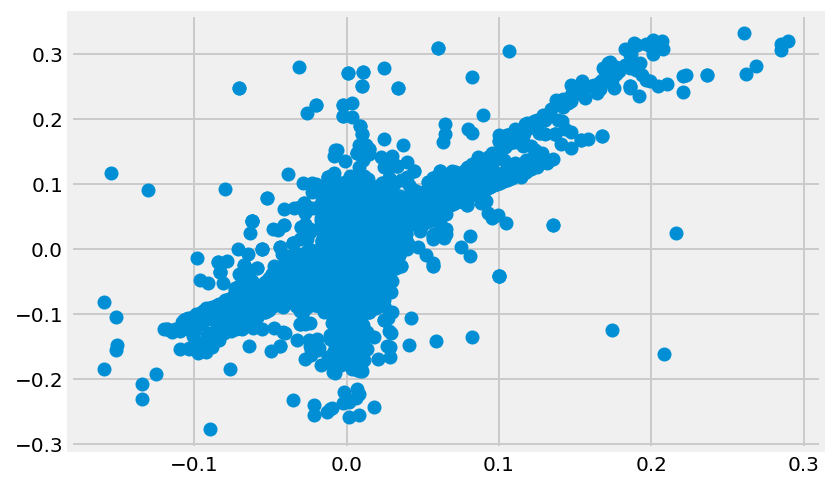

In [167]:
import matplotlib.pyplot as plt
plt.plot(pred_rf,test_response["lag_1d"],"o")

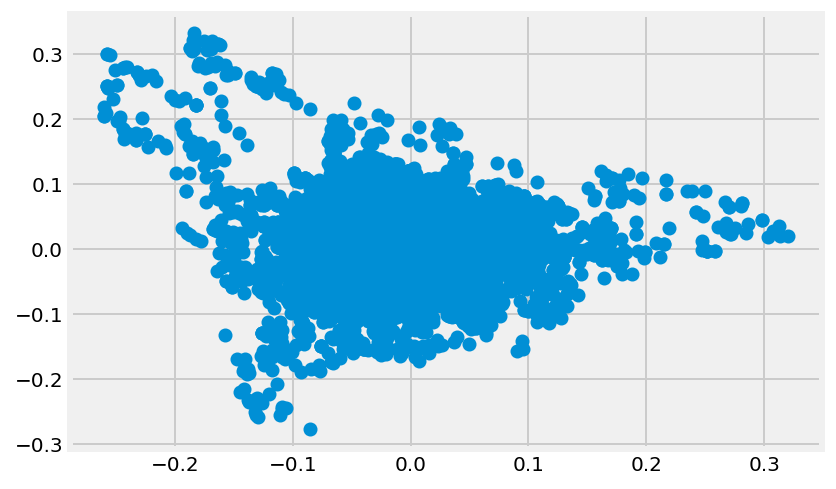

In [133]:
plt.plot(test_naive["lag_1d"],test_response["lag_1d"],"o")

In [170]:
import random
rand = []
for x in range(10):
    rand.append(random.randint(0,len(pred_rf)))

for i in rand:
    print("true value:",round(test_response["lag_4d"].iloc[i],2),"","predicted value:",round(pred_rf[i],2))
    #print(i)


true value: 0.05  predicted value: 0.01
true value: -0.29  predicted value: 0.01
true value: 0.02  predicted value: 0.02
true value: 0.1  predicted value: 0.04
true value: -0.13  predicted value: -0.09
true value: 0.07  predicted value: -0.03
true value: 0.01  predicted value: -0.03
true value: -0.09  predicted value: -0.01
true value: 0.06  predicted value: 0.0
true value: -0.18  predicted value: -0.04


In [171]:
for i in rand:
    print(test["title"].iloc[i])
    #print(i)

Use blockchain technology to prevent PNB like scam: Foreign data expert
Unpacking Facebook’s Bitcoin ban
Bitcoin’s Nosedive Hasn’t Hurt Red-Hot Coin Offerings
Nine suspects arrested over theft of bitcoin machines
Global Cryptocurrency Markets Improve in February as Bitcoin Rises Again
Ripple’s XRP crypto token is more volatile than just about everything
Bitcoin Has Triggered the Energy Arms Race
Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stellar, Litecoin, Cardano, NEO, EOS: Price Analysis, March 10
Supposed Bitcoin co-inventor sued for more than $10 billion in cryptocurrency
Wall Street embraces bitcoin


### 3.8 gbm with cv 

In [136]:
#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

start = time.time()

colnames = {"lag_1m":60,"lag_5m":300,"lag_10m":600,"lag_30m":1800,"lag_60m":3600,"lag_12h":43200,"lag_1d":86400,
           "lag_2d":172800,"lag_4d": 345600}

model = ["lag_1d"]
count = 0
for j in model:
    count+=1
    
    #a = np.concatenate((train_dummies,np.array(train_naive[j]).reshape(len(train_naive[j]),1),X),axis = 1)
    #b = np.concatenate((test_dummies,np.array(test_naive[j]).reshape(len(test_naive[j]),1),X_test),axis = 1)
    
    gbm = GradientBoostingRegressor(n_estimators = 500,validation_fraction = .75,
                                     n_iter_no_change = 2)
    
    max_features = [0.6,0.8]
    subsample = [.7]
    max_depth = [1,5]
    learning_rate = [.01]
    n_estimators=[200]

    param_grid = {'max_features': max_features,"max_depth":max_depth,
                 "subsample":subsample,"learning_rate":learning_rate}
    
    #grid_search = GridSearchCV(estimator = gbm, param_grid = param_grid, 
    #                      cv = 2, n_jobs = -1, verbose = 2,scoring = "neg_mean_squared_error")

    #rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, 
                               #cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    #grid_search.fit(X, train_response[j])

    #best_param = grid_search.best_params_

    gbm_d = GradientBoostingRegressor(
                                    )
    gbm_d.fit(X,train_response[j])

    pred = gbm_d.predict(X_test)
    pred_gbm = gbm_d.predict(X_test)

    print("gbm test error:",j,round(mean_squared_error(pred,test_response[j])/
                                                  mean_squared_error(test_response[j],test_naive[j]),5))
    #if count>0:
       # break 
print("time elapsed:",round((time.time()-start)/60,1),"minutes")

gbm test error: lag_1d 0.41563
time elapsed: 0.4 minutes


In [137]:
best_param

{'max_depth': None, 'max_features': 0.3, 'n_estimators': 500}

In [138]:
gbm_d.n_estimators

100

In [139]:
#grid_search.cv_results_

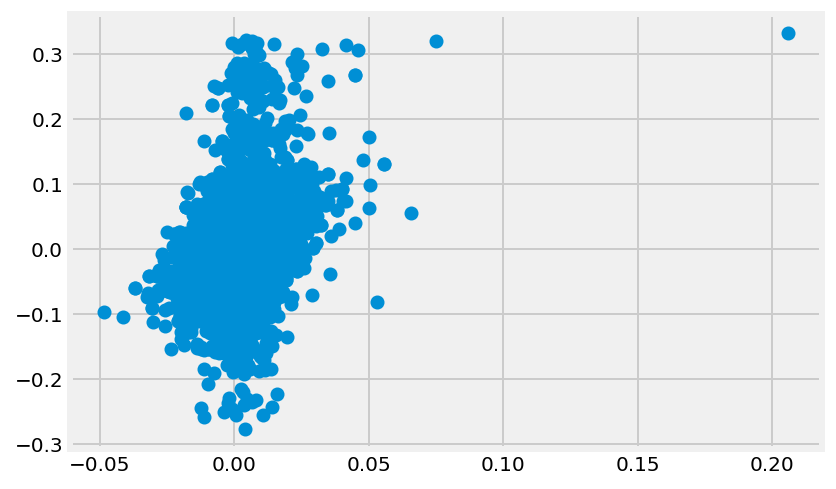

In [140]:
import matplotlib.pyplot as plt
plt.plot(pred,test_response["lag_1d"],"o")

In [166]:
import random
rand = []
for x in range(20):
    rand.append(random.randint(0,len(pred)))

for i in rand:
    print("true value:",round(test_response["lag_4d"].iloc[i],2),"","predicted value:",round(pred[i],2))
    #print(i)



true value: -0.11  predicted value: 0.01
true value: 0.03  predicted value: -0.01
true value: 0.12  predicted value: 0.01
true value: -0.18  predicted value: -0.0
true value: -0.17  predicted value: 0.0
true value: -0.13  predicted value: -0.02
true value: -0.14  predicted value: 0.0
true value: -0.0  predicted value: 0.01
true value: 0.07  predicted value: -0.0
true value: 0.01  predicted value: 0.0
true value: 0.04  predicted value: 0.02
true value: -0.07  predicted value: -0.0
true value: 0.0  predicted value: 0.01
true value: -0.14  predicted value: 0.01
true value: 0.04  predicted value: 0.0
true value: -0.14  predicted value: -0.0
true value: -0.06  predicted value: 0.0
true value: 0.03  predicted value: 0.0
true value: 0.06  predicted value: -0.0
true value: -0.13  predicted value: -0.01


#An error ocurred while starting the kernel
OMP: Error #15: Initializing libomp.dylib, but found libiomp5.dylib already initialized.
OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://openmp.llvm.org/

### 3.9 Final Scoring 

In [193]:
pred_rf

array([-0.05594974, -0.01795777, -0.02645109, ...,  0.00184953,
       -0.01749912,  0.12603116])

In [251]:
np.percentile(pred_rf,95)

0.0742969399851995

In [194]:
pred_rf[0]

-0.0559497400845878

In [279]:
def create_score(prediction):
    
    min_ = np.percentile(abs(prediction),2)
    max_ = np.percentile(abs(prediction),98)
    
    new_list = []
    
    for i in abs(prediction):
        if i < min_ or i> max_:
            new_list.append(10)
        else:
            new_list.append(round((i-min_)/(max_-min_)*10))
    return new_list

In [280]:
scoring = create_score(pred_rf)

In [281]:
min(scoring)

0.0

In [282]:
max(scoring)

10

## 4. Evaluation

Text(0,0.5,'Actual Daily Price Change')

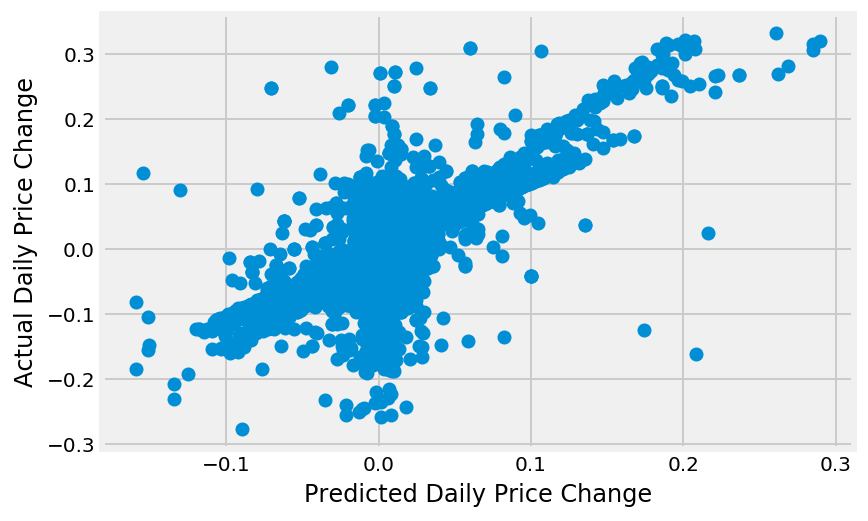

In [270]:
import matplotlib.pyplot as plt
plt.plot(pred_rf,test_response["lag_1d"],"o")
plt.xlabel('Predicted Daily Price Change')
plt.ylabel('Actual Daily Price Change')

In [300]:
import random
rand = []
for x in range(10):
    rand.append(random.randint(0,len(pred_rf)))

for i in rand:
    print("true value:",round(test_response["lag_4d"].iloc[i],2),"","predicted value:",round(pred_rf[i],2),"",
         "predicted scoring:",scoring[i])
    print("")
    print(test["title"].iloc[i])
    print("")
    print("")

true value: 0.11  predicted value: 0.0  predicted scoring: 0.0

Craig Wright, who once claimed to be Bitcoin founder Satoshi Nakamoto, sued for $10B by his deceased partner Dave Kleiman's estate for stealing $5B in bitcoin (Russell Brandom/The Verge)


true value: -0.21  predicted value: -0.02  predicted scoring: 2.0

Arun Jaitley has just killed India’s cryptocurrency party


true value: -0.04  predicted value: -0.02  predicted scoring: 2.0

Why did Ethereum Drop so hard? Bitcoin is Correcting, and Cryptocurrency Markets Follow.


true value: 0.3  predicted value: 0.16  predicted scoring: 10

Bitcoin slides below $6000; half its value lost in 2018 - Fox Business


true value: -0.04  predicted value: 0.05  predicted scoring: 4.0

Dutch Court Finds Bitcoin A Legitimate “Transferable Value”


true value: 0.14  predicted value: 0.12  predicted scoring: 10

Bitcoin plunges below $10,000 as major crypto exchange to share user details with US tax authorities


true value: 0.19  predicted val

## 5. Appendix